## FLIC config (first 6 hours)

This notebook recapitulates `flic/test/run_flic_config_6h.py`:

- Finds the project’s `flic/` directory (the one containing `flic_config.yaml`) and treats it as the base directory
- Forces `import flic` to come from this repo (not an installed package)
- Loads `flic_config.yaml`
- Resolves `data_dir`
- Loads all DFMs for the first 6 hours (0–360 minutes)
- Writes QC reports + experiment summary + feeding summary


In [1]:
from __future__ import annotations

import sys
from pathlib import Path


def find_flic_dir(start: Path) -> Path:
    """Find the `flic/` directory that contains `flic_config.yaml`."""

    start = start.resolve()

    def is_flic_dir(p: Path) -> bool:
        return (p / "flic_config.yaml").exists() and (p / "__init__.py").exists()

    # 1) Current directory (if user started kernel from inside flic/)
    if is_flic_dir(start):
        return start

    # 2) A direct child named flic (if user started kernel from repo root)
    if (start / "flic").is_dir() and is_flic_dir(start / "flic"):
        return (start / "flic").resolve()

    # 3) Walk parents looking for a flic/ child
    for parent in [start, *start.parents]:
        cand = parent / "flic"
        if cand.is_dir() and is_flic_dir(cand):
            return cand.resolve()

    raise FileNotFoundError(
        "Could not find the project 'flic' directory (expected to contain flic_config.yaml)."
    )


FLIC_DIR = find_flic_dir(Path.cwd())
REPO_ROOT = FLIC_DIR.parent

# Ensure we import the local repo's `flic` package.
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import yaml

from flic import Experiment

print("FLIC_DIR:", FLIC_DIR)
print("REPO_ROOT:", REPO_ROOT)
print("Imported flic from:", __import__("flic").__file__)


FLIC_DIR: /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic
REPO_ROOT: /home/spletch/GithubLocal/FLIC_R_Code/FLIC
Imported flic from: /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic/__init__.py


In [2]:
# Notebook settings (match defaults in the script), rooted at FLIC_DIR
CONFIG_PATH = (FLIC_DIR / "flic_config.yaml").resolve()
HOURS = 6.0
MINUTES = HOURS * 60.0

OUT_FEEDING_TXT = (FLIC_DIR / "test" / "feeding_summary_first_6h.txt").resolve()
OUT_EXPERIMENT_SUMMARY_TXT = (FLIC_DIR / "test" / "experiment_summary_first_6h.txt").resolve()
OUT_QC_DIR = (FLIC_DIR / "test" / "qc_reports_first_6h").resolve()

QC_DATA_BREAKS_MULTIPLIER = 4.0
QC_BLEEDING_CUTOFF = 50.0

print("CONFIG_PATH:", CONFIG_PATH)
print("OUT_FEEDING_TXT:", OUT_FEEDING_TXT)
print("OUT_EXPERIMENT_SUMMARY_TXT:", OUT_EXPERIMENT_SUMMARY_TXT)
print("OUT_QC_DIR:", OUT_QC_DIR)


CONFIG_PATH: /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic/flic_config.yaml
OUT_FEEDING_TXT: /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic/test/feeding_summary_first_6h.txt
OUT_EXPERIMENT_SUMMARY_TXT: /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic/test/experiment_summary_first_6h.txt
OUT_QC_DIR: /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic/test/qc_reports_first_6h


In [3]:
def resolve_data_dir(config_path: Path, data_dir_value: str | None) -> Path | None:
    if not data_dir_value:
        return None
    p = Path(data_dir_value)
    if p.is_absolute():
        return p
    # Interpret relative data_dir as relative to the config file directory.
    return (config_path.parent / p).resolve()


cfg = yaml.safe_load(CONFIG_PATH.read_text())
if not isinstance(cfg, dict):
    raise ValueError("Config YAML root must be a mapping/object.")

data_dir_value = cfg.get("data_dir")
resolved_data_dir = resolve_data_dir(CONFIG_PATH, data_dir_value)

print("config data_dir:", repr(data_dir_value))
print("resolved_data_dir:", resolved_data_dir)


config data_dir: 'TestData'
resolved_data_dir: /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic/TestData


In [4]:
# Load the experiment (first 6 hours)
exp = Experiment.load(
    CONFIG_PATH,
    data_dir=resolved_data_dir,
    range_minutes=(0.0, float(MINUTES)),
    parallel=True,
    executor="threads",
)

print("Loaded DFMs:", sorted(exp.dfms.keys()))
print("Treatments:", sorted(exp.design.treatments.keys()))


Loaded DFMs: [1, 2, 3, 4, 5, 6, 7, 8]
Treatments: ['Paired_Chrim', 'Paired_WCS', 'Unpaired_Chrim', 'Unpaired_WCS']


In [5]:
# Write QC + experiment summary
qc_dir = exp.write_qc_reports(
    OUT_QC_DIR,
    data_breaks_multiplier=float(QC_DATA_BREAKS_MULTIPLIER),
    bleeding_cutoff=float(QC_BLEEDING_CUTOFF),
)
summary_path = exp.write_summary(
    OUT_EXPERIMENT_SUMMARY_TXT,
    include_qc=True,
    qc_data_breaks_multiplier=float(QC_DATA_BREAKS_MULTIPLIER),
    qc_bleeding_cutoff=float(QC_BLEEDING_CUTOFF),
)

print("Wrote QC reports to:", qc_dir)
print("Wrote experiment summary to:", summary_path)


Wrote QC reports to: /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic/test/qc_reports_first_6h
Wrote experiment summary to: /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic/test/experiment_summary_first_6h.txt


In [6]:
# Build the design and feeding summary tables (and write feeding summary txt)
design_df = exp.design.design_table().sort_values(["Treatment", "DFM", "Chamber"])
summary_df = exp.design.feeding_summary()
if not summary_df.empty and all(c in summary_df.columns for c in ("Treatment", "DFM", "Chamber")):
    summary_df = summary_df.sort_values(["Treatment", "DFM", "Chamber"])

OUT_FEEDING_TXT.parent.mkdir(parents=True, exist_ok=True)
with OUT_FEEDING_TXT.open("w", encoding="utf-8") as f:
    f.write("FLIC experiment test run\n")
    f.write("=======================\n\n")
    f.write(f"Config: {CONFIG_PATH}\n")
    f.write(f"Config data_dir: {data_dir_value!r}\n")
    f.write(f"Resolved data_dir: {str(resolved_data_dir) if resolved_data_dir else '(none)'}\n")
    f.write(f"Range minutes: (0, {MINUTES})\n")
    f.write(f"Loaded DFMs: {sorted(exp.dfms.keys())}\n")
    f.write(f"Treatments: {sorted(exp.design.treatments.keys())}\n\n")

    f.write("Experiment design (DFM/Chamber -> Treatment)\n")
    f.write("--------------------------------------------\n")
    if design_df.empty:
        f.write("(empty)\n\n")
    else:
        f.write(design_df.to_string(index=False))
        f.write("\n\n")

    f.write("Feeding summary\n")
    f.write("--------------\n")
    if summary_df.empty:
        f.write("(empty)\n")
    else:
        f.write(summary_df.to_string(index=False))
        f.write("\n")

print("Wrote feeding summary to", OUT_FEEDING_TXT)


Wrote feeding summary to /home/spletch/GithubLocal/FLIC_R_Code/FLIC/flic/test/feeding_summary_first_6h.txt


In [7]:
# Quick previews
print("Design table:")
display(design_df.head(12))

print("Feeding summary:")
display(summary_df.head(12))


Design table:


,DFM,Chamber,Treatment
24,1,3,Paired_Chrim
25,1,5,Paired_Chrim
26,2,4,Paired_Chrim
27,2,6,Paired_Chrim
28,3,3,Paired_Chrim
29,3,5,Paired_Chrim
30,4,4,Paired_Chrim
31,4,6,Paired_Chrim
32,5,1,Paired_Chrim
33,6,2,Paired_Chrim


Feeding summary:


,Treatment,DFM,Chamber,PI,EventPI,LicksA,LicksB,EventsA,EventsB,MeanDurationA,...,MinIntA,MaxIntA,MeanIntB,MedianIntB,MinIntB,MaxIntB,OptoOn_sec_A,OptoOn_sec_B,StartMin,EndMin
24,Paired_Chrim,1,3,-0.587786,0.138462,4.151348,5.815760,37.0,28.0,1.686486,...,0.0,176.0,129.080365,120.0,0.0,372.0,27.0,27.0,0.0,0.0
25,Paired_Chrim,1,5,-0.438438,-0.033333,5.787596,7.321865,58.0,62.0,4.031034,...,-1.0,158.0,105.603548,102.0,0.0,358.0,47.4,47.4,0.0,0.0
26,Paired_Chrim,2,4,-0.510018,-0.095238,4.049842,5.365851,19.0,23.0,2.905263,...,0.0,191.0,129.509501,131.0,0.0,321.0,29.8,29.8,0.0,0.0
27,Paired_Chrim,2,6,-0.905662,-0.604520,4.665998,9.892013,35.0,142.0,2.811429,...,0.0,216.0,115.542027,118.0,-49.0,303.0,28.2,28.2,0.0,0.0
28,Paired_Chrim,3,3,-0.342713,0.092308,5.931713,7.091485,71.0,59.0,3.661972,...,0.0,279.0,123.366901,120.0,0.0,385.0,30.0,30.0,0.0,0.0
29,Paired_Chrim,3,5,-0.610978,-0.203125,5.700540,8.131953,51.0,77.0,4.270588,...,-11.0,207.0,121.614267,121.0,-2.0,380.0,20.6,20.6,0.0,0.0
30,Paired_Chrim,4,4,-0.110533,-0.050505,5.114039,5.405856,47.0,52.0,3.370213,...,-12.0,196.0,75.242094,76.0,0.0,263.0,131.8,131.8,0.0,0.0
31,Paired_Chrim,4,6,-0.283693,-0.022222,4.683131,5.418472,22.0,23.0,4.663636,...,0.0,265.0,138.903299,145.0,2.0,350.0,42.2,42.2,0.0,0.0
32,Paired_Chrim,5,1,-0.492478,-0.234568,5.819569,7.620862,62.0,100.0,3.903226,...,0.0,264.0,112.447766,110.0,0.0,342.0,29.8,29.8,0.0,0.0
33,Paired_Chrim,6,2,-0.927947,-0.690476,3.414953,7.766861,13.0,71.0,2.261538,...,2.0,246.0,82.216387,86.0,-34.0,410.0,21.4,21.4,0.0,0.0


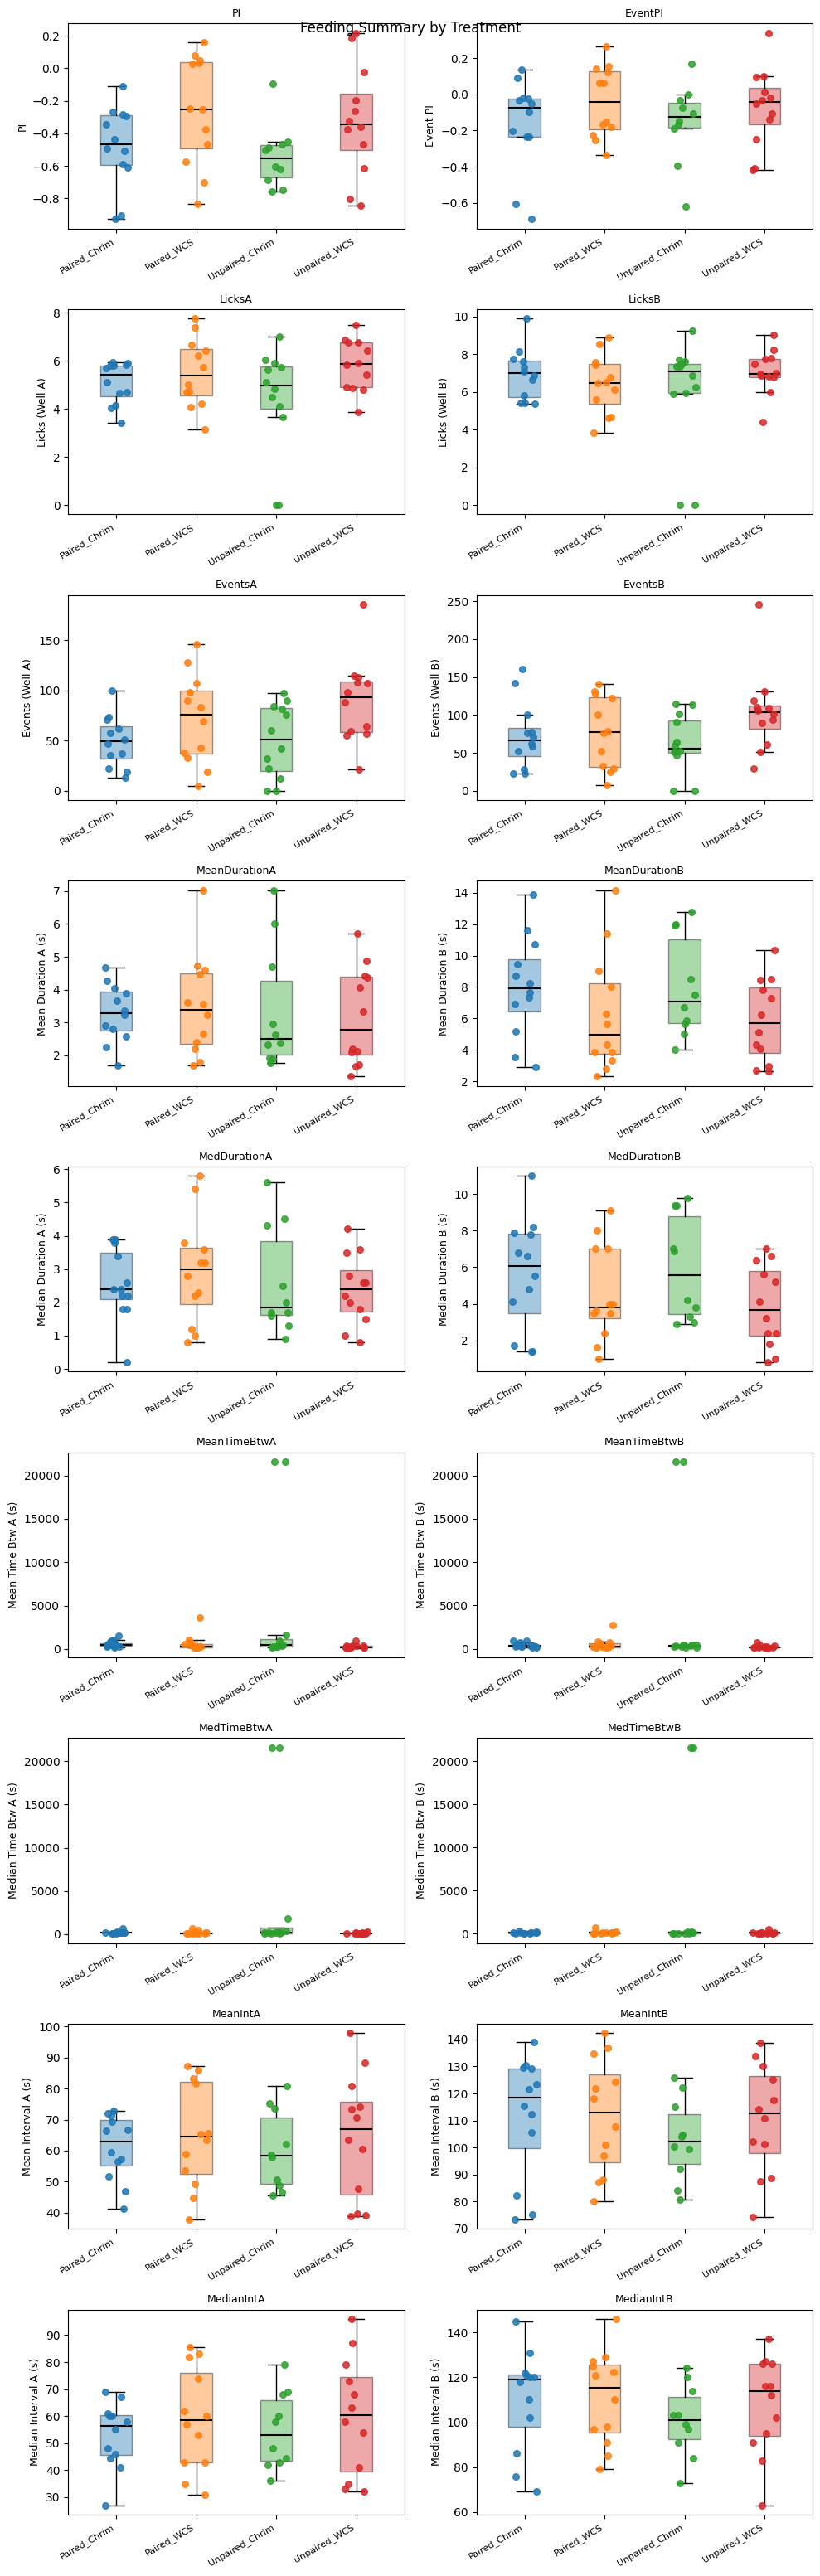

In [8]:
fig=exp.plot_feeding_summary()
fig.savefig(FLIC_DIR / "test" / "feeding_summary_first_6h.png")

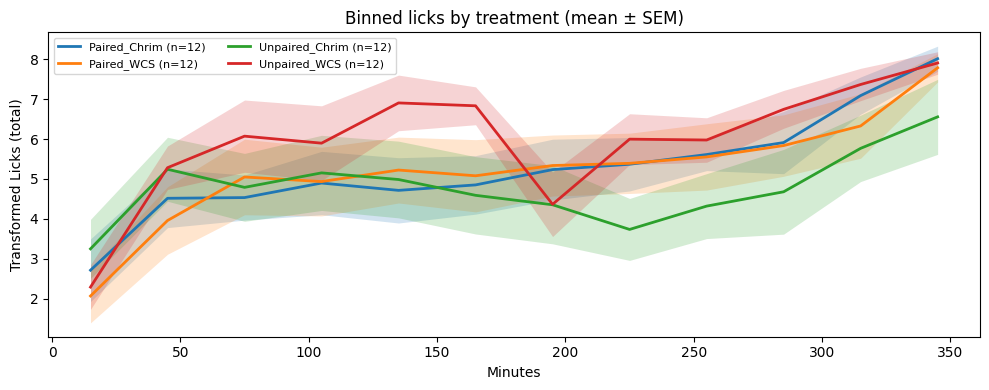

In [9]:
fig2=exp.plot_binned_licks_by_treatment()
fig2.savefig(FLIC_DIR / "test" / "binned_licks_by_treatment_first_6h.png")

In [11]:
from flic import DFM, Parameters

dfm = DFM.load(1, Parameters.two_well(), data_dir="flic/TestData", range_minutes=(0, 360))
fig = dfm.plot_licks()

FileNotFoundError: data_dir does not exist: flic/TestData